# Exploration in Gratings, Gaussian Kernels and Convolutions

In an attempt to learn the fundamental building blocks of motion perception in the brain, through the lens of computational neuroscience, this notebook explores fundamental concepts in signal processing, focusing on visual stimuli and filtering techniques. We'll investigate:
 
1. Sinusoidal gratings - creating and manipulating oriented patterns, in 2D and in time as well.
2. Gaussian kernels - understanding spatial filtering
3. Convolutions - applying filters to images and spatiotemporal stimuli.
 
These concepts are essential in image processing, computer vision, and neuroscience for analyzing how visual systems process information.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

## Sinusodial Gratings
$$g(x,y)=Asin(2πf(xcosθ+ysinθ)+ϕ)$$

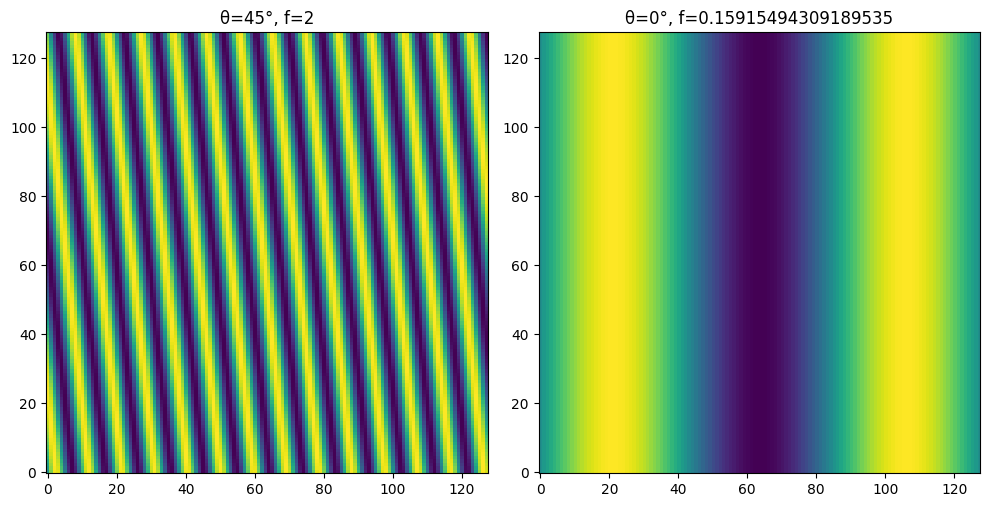

In [3]:
def sinusoidal_grating(A, f, theta, phi, grid_x: np.ndarray, grid_y: np.ndarray):
    '''
    Takes a grid, amplititude, frequence, phase and an angle orientation and returns the sinusoidal grating
    grid_x: (M x N)
    grid_y: (N x M)
    '''
    rotated_grid_x = grid_x * np.cos(theta) + grid_y * np.sin(theta)
    grating = A * np.sin(2 * np.pi * f * (rotated_grid_x) + phi)
    return grating


def plot_sinusoidal_grating():
    grid_size = 128
    x = np.linspace(0, 3 * np.pi, grid_size)
    y = np.linspace(0, 1, grid_size)
    phi = 0
    A = 10
    grid_x, grid_y = np.meshgrid(x, y)
    fig, axes = plt.subplots(1, 2, figsize=(10, 10))

    params = [
        {'theta': np.pi/4, 'f': 2},  # 45 degrees, lower frequency
        {'theta': 0, 'f': 1/(2*np.pi)}, # horizontal at a natural sine frequency
    ]

    for ax, param in zip(axes.flat, params):
        grating = sinusoidal_grating(A, param['f'], param['theta'], phi, grid_x, grid_y)
        im = ax.imshow(grating, origin = 'lower')
        ax.set_title(f"θ={param['theta']*180/np.pi:.0f}°, f={param['f']}")

    plt.tight_layout()

plot_sinusoidal_grating()



## Drifting Sinusodial Grating
$$g(x,y,t)=Asin(2πf(xcosθ+ysinθ)+\phi-2πft)$$



In [77]:
import matplotlib.animation as animation
from IPython.display import HTML
%matplotlib inline


def animate(frames_array: np.ndarray):
    # Create a figure and axis for the animation
    fig, ax = plt.subplots(figsize=(8, 8))
    frames = frames_array.shape[0]

    # Initialize the plot with the first frame
    im = ax.imshow(frames_array[0], animated=True, cmap='gray', origin = 'lower', vmin=-1, vmax=1)

    # Animation update function
    def update(frame):
        im.set_array(frames_array[frame])
        return [im]

    # Create the animation
    anim = animation.FuncAnimation(
        fig, update, frames=frames,
        interval=50, blit=True
    )
    plt.close()
    return HTML(anim.to_jshtml())

In [30]:
import matplotlib.animation as animation
from IPython.display import HTML
%matplotlib inline


def sinusodial_grating_3d(A: float, f: float, time_f: float, frames: int, theta: float, phi: float, grid: np.ndarray):
    x, y  = grid[0], grid[1]
    X, Y = np.meshgrid(x, y)
    drifting_grid = np.zeros((frames, len(x), len(y)))

    for t in range(frames):
        # fraction of frames completed. 2*np.pi is a full cycle in the prescribed frames. time_f controls how fast
        phase_shift = phi - 2 * np.pi * time_f * (t / frames)
        drifting_grid[t] = sinusoidal_grating(
            A, 
            f, 
            theta,
            phase_shift,
            X,
            Y,
        )
    return drifting_grid




frames = 100
grid_size = 128
x = np.linspace(0, 10 * np.pi, 128)
y = np.linspace(0, 10 * np.pi, 128)
grid = np.stack([x, y])
drifting_grid = sinusodial_grating_3d(10, 1/(2*np.pi), 10, frames, np.pi/4, 0, grid)


# Create a figure and axis for the animation
fig, ax = plt.subplots(figsize=(8, 8))

# Initialize the plot with the first frame
im = ax.imshow(drifting_grid[0], animated=True, cmap='gray', origin = 'lower', vmin=-1, vmax=1)
ax.set_title(f"θ={theta*180/np.pi:.0f}°, f={f}")

# Animation update function
def update(frame):
    im.set_array(drifting_grid[frame])
    return [im]

# Create the animation
anim = animation.FuncAnimation(
    fig, update, frames=frames,
    interval=50, blit=True
)
plt.close()
HTML(anim.to_jshtml())



## Convolutions

### First, we implement a basic spatial grating

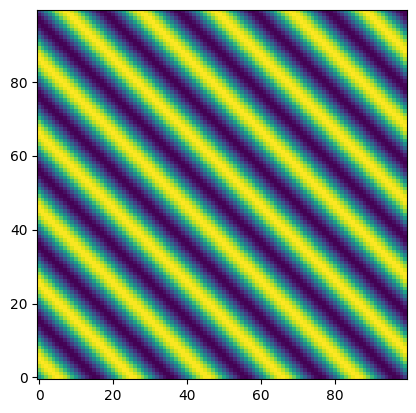

In [60]:
def spatial_grating(A: float, phi: float, f: float, theta: float, grid_size: int = 100) -> np.ndarray:
    x = np.linspace(0, 10 * np.pi, grid_size)
    y = np.linspace(0, 10 * np.pi, grid_size)
    x_grid, y_grid = np.meshgrid(x, y)
    grating = A * np.sin(2 * np.pi * f * (x_grid * np.cos(theta) + y_grid * np.sin(theta)) + phi)
    return grating

def plot_grating(grating: np.ndarray):
    fig = plt.figure()
    plt.imshow(grating, origin='lower')
    plt.show()

grating = spatial_grating(1.0, 0.0, 10 * np.pi, np.pi / 4, 100)
plot_grating(grating)


### Now, we implement a Gaussian Kernel

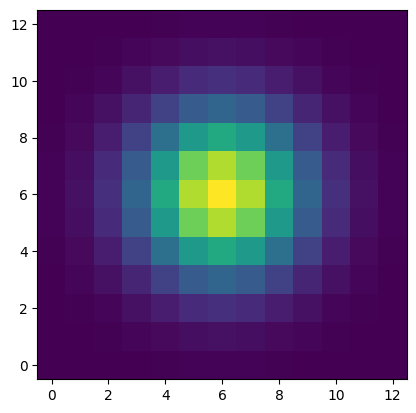

In [12]:
def gaussian_kernel(sigma: float, size: int) -> np.ndarray:
    """
    Create a 2D Gaussian kernel with specified standard deviation and size.
    
    This function generates a square 2D Gaussian kernel that can be used for 
    image filtering/smoothing operations. The kernel is normalized so the sum 
    of all elements equals 1, ensuring that the filter preserves the overall 
    intensity of the image.
    
    Parameters
    ----------
    sigma : float
        Standard deviation of the Gaussian distribution. Controls the spread
        of the kernel. Larger values create a wider, more gradual falloff.
        Must be positive.
    size : int
        Width and height of the kernel in pixels. Must be an odd number to
        ensure the kernel is symmetric around its center pixel.
        
    Returns
    -------
    np.ndarray
        A 2D normalized Gaussian kernel of shape (size, size).
        Values are floating point numbers in range [0, 1].
        
    Raises
    ------
    ValueError
        If sigma <= 0 or if size is not an odd number.
        
    Notes
    -----
    The kernel is computed using the 2D Gaussian function:
        G(x,y) = exp(-(x² + y²)/(2σ²))
    
    where x and y are distances from the kernel center.
    
    The kernel is normalized by dividing all elements by their sum,
    ensuring that Σ G(x,y) = 1 over the entire kernel.
    
    Examples
    --------
    >>> kernel = gaussian_kernel(sigma=1.0, size=5)
    >>> print(kernel.shape)
    (5, 5)
    >>> print(np.sum(kernel))
    1.0
    """
    if sigma <= 0:
        raise ValueError("sigma must be positive")
    if size % 2 == 0:
        raise ValueError("size must be odd")

    # We use (size-1)/2 to create a symmetric range around 0.
    # For example, with size=5:
    # - We want 5 points: [-2, -1, 0, 1, 2]
    # - The middle point (0) is the kernel center
    # - We have equal number of points (2) on each side of 0
    # - Total points = 2 (left) + 1 (center) + 2 (right) = 5 
    x = np.linspace(-(size-1)/2, (size-1)/2, size)
    x_grid, y_grid = np.meshgrid(x, x)
    kernel = np.exp(-(x_grid**2 + y_grid**2) / (2 * sigma**2)) # Note: we omit the constant here as it is normalized out
    return kernel / np.sum(kernel)

kernel = gaussian_kernel(2, 13)

figure = plt.figure()
plt.imshow(kernel, origin = 'lower')
plt.show()

### We will use this Guassian kernel in a Convolution

Below is the non-vectorized implementation of a convolution.

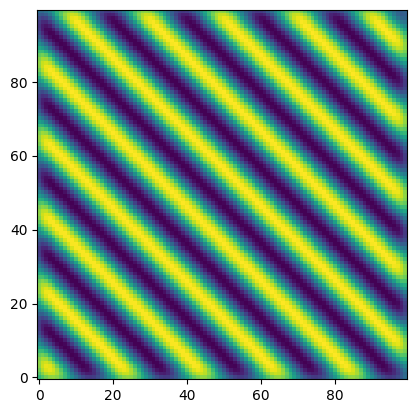

In [116]:
def convolution_non_vectorized(image: np.ndarray, kernel: np.ndarray) -> np.ndarray:
    if kernel.shape[0] % 2 == 0 or (kernel.shape[0] != kernel.shape[1]):
        raise ValueError("kernel is either not of odd dimension, or is not square")
    kernel_size = kernel.shape[0]
    kernel_offset = kernel_size // 2 
    image_height, image_width = image.shape[0], image.shape[1]
    result = np.zeros_like(image)

    for y in range(image_height):
        for x in range(image_width):
            # Ex. For kernel_size = 7, kernel_offset = [-3, 3], and
            # i takes on values: [-3, -2, -1, 0, 1, 2, 3]
            weighted_sum = 0
            for k_y in range(-kernel_offset, kernel_offset + 1):
                for k_x in range(-kernel_offset, kernel_offset + 1): 
                    if (x+k_x < 0 or x+k_x >= image_width or y+k_y < 0 or y+k_y >= image_height):
                        continue
                    # Array indices must be offset since they cannot be negative
                    weighted_sum += image[y+k_y][x+k_x] * kernel[k_y+kernel_offset][k_x+kernel_offset] 
            result[y][x] = weighted_sum
    return result

image = spatial_grating(1.0, 0.0, 10 * np.pi, np.pi / 4, 100)
kernel = gaussian_kernel(2, 31)
convolved = convolution_non_vectorized(image, kernel)

figure = plt.figure()
plt.imshow(convolved, origin='lower')
plt.show()

Now, we will implement the vectorized version of the convolution

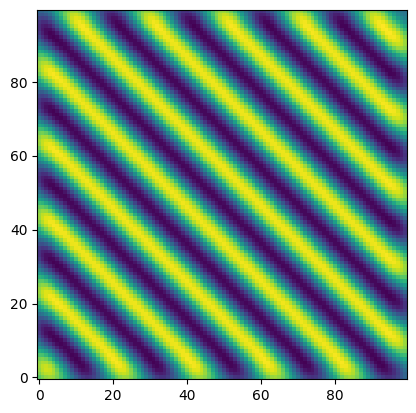

In [124]:
def convolution_vectorized(image: np.ndarray, kernel: np.ndarray) -> np.ndarray:
    # Determine image and kernel size

    # Create a padded image so that the kernel can overflow off the edge

    # Iterate through the (x, y) coordinates of the image
    # Grab a kernel-sized portion of the padded image, multiply it (elementwise) with the kernel
    # Take a sum and set the result[x, y] to that resulting sum

    img_h, img_w = image.shape[0], image.shape[1]
    pad = kernel.shape[0] // 2

    # Alternatively: padded_image = np.pad(image, pad_width=pad, mode='constant', constant_values=0)
    padded_image = np.zeros((img_h+2*pad , img_w+2*pad))
    padded_image[pad:img_h+pad , pad:img_w+pad] = image

    result = np.zeros_like(image)

    for y in range(img_h):
        for x in range(img_w):
            region = padded_image[y: y+kernel.shape[0], x:x+kernel.shape[0]]
            result[y][x] = np.sum(region * kernel)
    
    return result


gauss_k = gaussian_kernel(3.0, 51)
image = spatial_grating(1.0, 0.0, 10 * np.pi, np.pi / 4, 100)
convolved = convolution_vectorized(image, gauss_k)

fig = plt.figure()
plt.imshow(convolved, origin='lower')
plt.show()

### Here's the convolution, but with a matrix-multiplication maximalist approach.

The explanation:

1/ `sliding_window_view` creates a view of overlapping windows/patches across your array without actually copying the data. Let's break it down with a simple example:

```python
# Create a simple 4x4 array
arr = np.arange(16).reshape(4, 4)
print("Original array:")
print(arr)
# [[  0,  1,  2,  3]
#  [  4,  5,  6,  7]
#  [  8,  9, 10, 11]
#  [ 12, 13, 14, 15]]

# Create sliding windows of size (2, 2)
windows = np.lib.stride_tricks.sliding_window_view(arr, (2, 2))
print("\nWindows shape:", windows.shape)  # (3, 3, 2, 2)
print("\nFirst window:")
print(windows[0, 0])  # Top-left 2x2 window
# [[ 0,  1]
#  [ 4,  5]]

print("\nSecond window (moving right):")
print(windows[0, 1])  # Top-middle 2x2 window
# [[ 1,  2]
#  [ 5,  6]]
```

- For a convolution with a k×k kernel, sliding_window_view creates a 4D array where:
- First two dimensions (h, w) represent the position of the window
- Last two dimensions (k_h, k_w) represent the window contents

Key points:
- It's memory efficient because it creates a view rather than copying data
- Each window represents the neighborhood that the kernel will operate on
- The resulting shape for input (H,W) and window (k,k) is (H-k+1, W-k+1, k, k)

Q: Why (H-k+1)?
Position the window at the start (index 0):
- Window covers indices 0 to (k-1)
Keep sliding until we can't move further:
- Last valid position is when the window ends at index (N-1)
- If window ends at (N-1), its start position must be at (N-k)
Count total possible positions:
- First position starts at index 0
- Last position starts at index (N-k)
- Therefore, number of positions = (N-k) - 0 + 1 = N-k+1


2/ This reshape operation converts the 4D array of windows into a 2D matrix that's suitable for matrix multiplication. Let's break it down:

```python
# Let's say we have:
# - 6x6 image
# - 3x3 kernel
# - windows shape is (4, 4, 3, 3) before reshape
#   - 4x4 possible window positions (6-3+1 = 4 in each direction)
#   - 3x3 is the window/kernel size

# Original windows shape: (4, 4, 3, 3)
# After reshape(-1, 9): (16, 9)
#   - -1 tells numpy to automatically calculate this dimension (4*4 = 16)
#   - 9 is k_h * k_w (3*3)

# Visual representation:
Before reshape:
[
    [window1_1, window1_2, window1_3, window1_4],
    [window2_1, window2_2, window2_3, window2_4],
    [window3_1, window3_2, window3_3, window3_4],
    [window4_1, window4_2, window4_3, window4_4]
]
where each window is 3x3

After reshape:
[
    [window1_1_flattened],  # 9 elements
    [window1_2_flattened],  # 9 elements
    [window1_3_flattened],  # 9 elements
    ...
    [window4_4_flattened]   # 9 elements
]
# Total: 16 rows × 9 columns
```

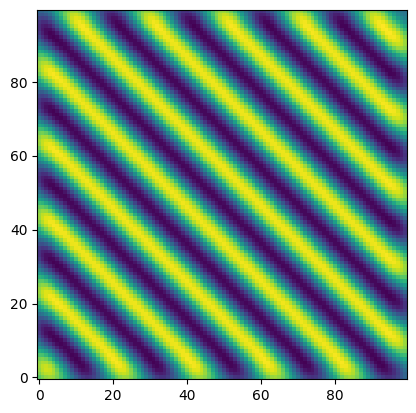

In [138]:
def convolution_matrix(image: np.ndarray, kernel: np.ndarray) -> np.ndarray:
    # Get dimensions
    k_h, k_w = kernel.shape
    i_h, i_w = image.shape
    pad = k_h // 2
    
    # Step 1: Create padded image
    padded = np.pad(image, pad, mode='constant', constant_values=0)
    
    # Step 2: Create patches/windows of the image
    # Each row will represent one window that the kernel will operate on
    windows = np.lib.stride_tricks.sliding_window_view(padded, (k_h, k_w))
    windows = windows.reshape(-1, k_h * k_w)  # Flatten each window
    
    # Step 3: Reshape kernel into a column vector
    kernel_vec = kernel.reshape(-1)
    
    # Step 4: Perform matrix multiplication and reshape result
    result = np.dot(windows, kernel_vec).reshape(i_h, i_w)
    
    return result

gauss_k = gaussian_kernel(3.0, 51)
image = spatial_grating(1.0, 0.0, 10 * np.pi, np.pi / 4, 100)
convolved_matrix = convolution_matrix(image, gauss_k)

fig = plt.figure()
plt.imshow(convolved_matrix, origin='lower')
plt.show()

### scipy.convolve2d vs manual implementation

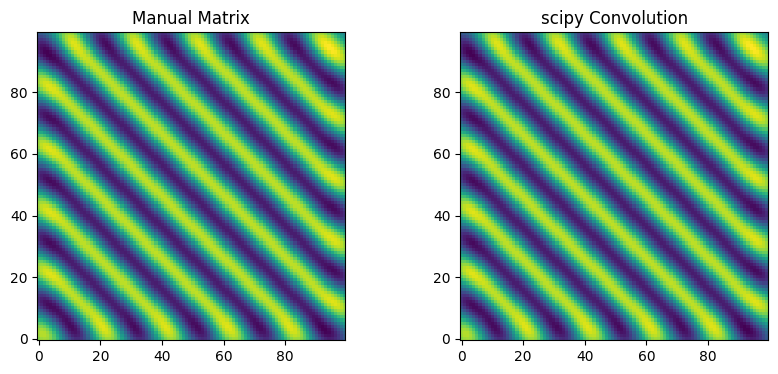

Convolution difference total: %v -1.6953631424079796e-13


In [141]:
from scipy.signal import convolve2d

gauss_k = gaussian_kernel(4.0, 51)
image = spatial_grating(1.0, 0.0, 10 * np.pi, np.pi / 4, 100)
convolved_matrix = convolution_matrix(image, gauss_k)

built_in_convolution = convolve2d(image, gauss_k, mode='same', boundary='fill', fillvalue=0)

fig = plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Manual Matrix")
plt.imshow(convolved_matrix, origin='lower')

plt.subplot(1, 2, 2)
plt.title("scipy Convolution")
plt.imshow(built_in_convolution, origin="lower")

plt.show()

def difference(first: np.ndarray, second: np.ndarray):
    return np.sum(second - first)

print("Convolution difference total: %v", difference(convolved_matrix, built_in_convolution))

## Per-frame 2D Convolution

The implementation below applies a 2D convolution to each frame. Next up will we apply a 3D convolution across the temporal dimension as well.

In [89]:
def convolution_2d_per_frame(drifting_grid: np.ndarray, kernel: np.ndarray) -> np.ndarray:
    """
    drifting_grid: a numpy array of shape (frames, width, height) where each frame is a grid of values
    kernel: the kernel is convolved with each frame
    """

    # Goal is to apply the convolution to each frame
    # Easiest solution is to iterate through each frame and apply the convolution using the vectorized implementation above
    # Q: Is there a more efficient, vectorized approach?

    # Pad each frame
    # Iterate through each frame
    # Iterate through all points in the frame
    # Calculate convolution of kernel with selected area

    frames = drifting_grid.shape[0]
    grid_size = drifting_grid.shape[1]
    result = np.zeros_like(drifting_grid)
    kernel_size = kernel.shape[0]
    pad = kernel_size // 2 # expect kernel to be odd sized
    padded = np.zeros((frames, 2 * pad + grid_size, 2 * pad + grid_size))
    padded[:, pad:pad+grid_size, pad:pad+grid_size] = drifting_grid

    for t in range(frames):
        frame = padded[t]
        for y in range(grid_size):
            for x in range(grid_size):
                result[t][y][x] = np.sum(
                    kernel * frame[y:y+kernel_size,x:x+kernel_size] # Shift the padded index by kernel_size
                )
        
    return result


grid_size = 100
grid = np.stack([
    np.linspace(0, 10 * np.pi, grid_size),
    np.linspace(0, 10 * np.pi, grid_size)
])
drifting_sinusodial = sinusodial_grating_3d(1.0, 10 * np.pi, 5, 100, np.pi / 4, 0, grid)

# grid_size=128
# frames = 100
# x = np.linspace(0, 10 * np.pi, grid_size)
# y = np.linspace(0, 10 * np.pi, grid_size)
# grid = np.stack([x, y])
# drifting_sinusodial = sinusodial_grating_3d(10, 1/(2*np.pi), 10, frames, np.pi/4, 0, grid)
# kernel = gaussian_kernel(2.0, 13)

# result = convolution_2d_per_frame(drifting_sinusodial, kernel)
# animate(result)


# 3D Convolution

Steps:
- Ensure the stimulus is correctly implemented
- Implement a kernel function that accepts two sigmas (one for time, and one for space) 
- Implement the 3D convolution function

## Manual implementation of a 3D Gaussian Kernel and Convolution

In [91]:
from typing import Tuple
# Define a 3D stimulus
grid = np.stack([
    np.linspace(0, 10 * np.pi, 100),
    np.linspace(0, 10 * np.pi, 100)
])
stimulus = sinusodial_grating_3d(1.0, 10 * np.pi, 5.0, 100, np.pi / 4, 0.0, grid)
animate(stimulus)

def gaussian_kernel_3d(sigma_xy: float, sigma_t: float, size: Tuple[int, int, int]) -> np.ndarray:
    # Q: how do I correctly construct the resultant array?
    t_size, y_size, x_size = size
    x = np.linspace(-(x_size // 2), x_size // 2, x_size)
    y = np.linspace(-(y_size // 2), y_size // 2, y_size)
    t = np.linspace(-(t_size // 2), t_size // 2, t_size)

    # We use `indexing=ij` here because we want to preserve the structure
    # of the (t, y, x) 3-d matrix as that is how we will be referencing
    # values across time and space. 
    # xy indexing would 
    T, Y, X = np.meshgrid(t, y, x, indexing='ij')
    spatial = (X**2 + Y**2) / (2 * sigma_xy**2)
    temporal = T**2 / (2 * sigma_t**2)
    kernel = np.exp(-(spatial + temporal))

    return kernel / np.sum(kernel)

def convolution_3d(frames: np.ndarray, kernel: np.ndarray) -> np.ndarray:
    print(f"input shapes -> frames: {frames.shape}, kernel: {kernel.shape}")
    result = np.zeros_like(frames)
    input_t_size, input_y_size, input_x_size = frames.shape
    t, y, x = kernel.shape
    pad_t, pad_y, pad_x = t // 2, y // 2, x // 2
    padded = np.pad(frames, pad_width = [(pad_t, pad_t), (pad_y, pad_y), (pad_x, pad_x)])
    print(f"padded shape: {padded.shape}")

    for i in range(input_t_size):
        for j in range(input_y_size):
            for k in range(input_x_size):
                # Take a full kernel-sized chunk from the padded input and 
                # compute elementwise product with the kernel
                product = padded[i: i + t, j: j + y, k: k + x] * kernel
                result[i][j][k] = np.sum(product)
    return result

kernel = gaussian_kernel_3d(sigma_xy=0.1, sigma_t=5.0, size = (20, 3, 3))
stimulus = sinusodial_grating_3d(10, 10 * np.pi, 5.0, 100, np.pi / 4, 0.0, grid)
result = convolution_3d(stimulus, kernel)
animate(result)


input shapes -> frames: (100, 100, 100), kernel: (20, 3, 3)
padded shape: (120, 102, 102)


## Using ndimage.convolve

In [92]:
from scipy import ndimage

result_inbuilt = ndimage.convolve(stimulus, kernel, mode='constant', cval=0.0) 
difference = np.abs(result - result_inbuilt)
print(f"Max difference: {np.max(difference)}")

animate(result_inbuilt)




Max difference: 1.158739013213449


# Playing around with a simple Convolution

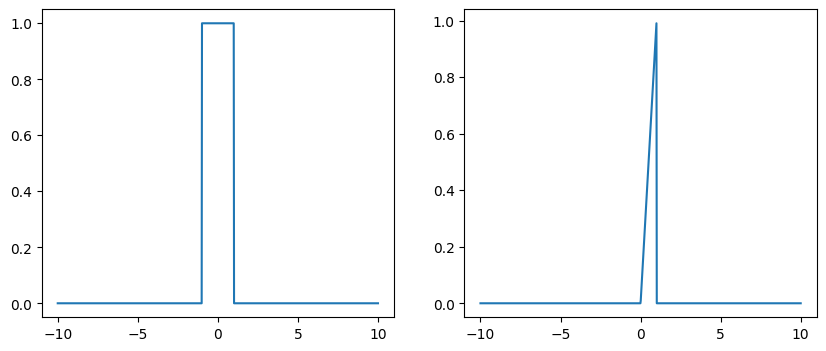

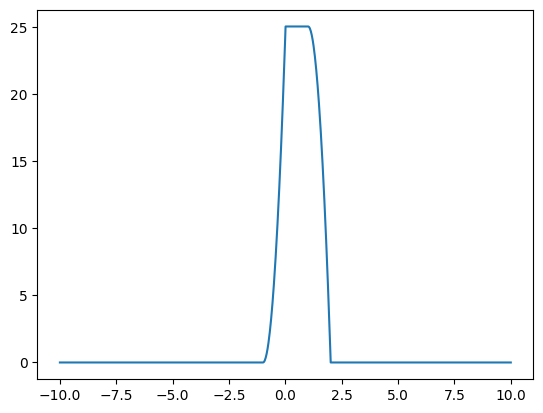

In [101]:
import numpy as np
import matplotlib.pyplot as plt

t = np.linspace(-10, 10, 1000)
f = np.where((t >= -1.0) & (t <= 1.0), 1.0, 0.0)
g = np.where((t >= 0.0) & (t <= 1.0), t, 0.0)


figure = plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(t, f)

plt.subplot(1, 2, 2)
plt.plot(t, g)

plt.show()

convolved = np.convolve(f, g, mode = 'same')
figure = plt.figure()
plt.plot(t, convolved)
plt.show()



## Fourier Transforms

Note: `np.fft.fftfre` is a NumPy function that generates an array of frequency bin centers corresponding to the output of the FFT. In other words, when you perform a Fast Fourier Transform (FFT) on a time-domain (or spatial-domain) signal, you obtain an array of complex numbers representing amplitude and phase for different frequency components. The fftfreq function tells you which frequencies these components correspond to.

Question: How does the FFT algorithm work? Why do the # of bins need to correspond to the length of the discrete signal?

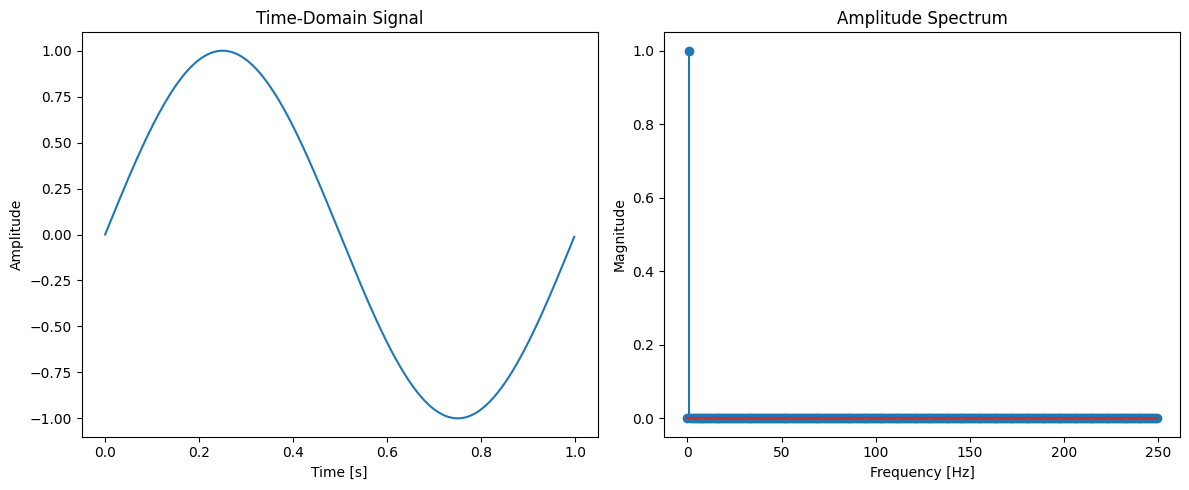

In [131]:
import numpy
import matplotlib.pyplot as plt

fs = 500            # Sampling frequency (Hz)
f = 1
t = np.linspace(0, 1, fs, endpoint=False)
signal = np.sin(t * 2 * np.pi * f)

fft_vals = np.fft.fft(signal)
fft_freq = np.fft.fftfreq(len(signal), 1/fs)

# Only use the positive half of frequencies for plotting
pos_mask = fft_freq >= 0
fft_freq_pos = fft_freq[pos_mask]
fft_magnitude = np.abs(fft_vals[pos_mask]) * 2 / len(signal)  # normalize amplitude

# Plot the time-domain signal
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(t, signal)
plt.title("Time-Domain Signal")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")

# Plot the amplitude spectrum
plt.subplot(1, 2, 2)
plt.stem(fft_freq_pos, fft_magnitude)
plt.title("Amplitude Spectrum")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude")
plt.tight_layout()
plt.show()


